# Jonathan Dyer & Sriman Kolachalam

# Overview

We hope to help solve the water crisis problem in Tanzania, where nearly 25 million people—over 40% of all Tanzanians—lack access to safe water. More details about this problem are found at water.org (https://water.org/our-impact/tanzania/) and Drop4Drop (https://drop4drop.org/tanzanias-water-crisis/). With this in mind, we look to study one potential area of the water problem in an effort to improve access to water. By analyzing the health of water pumps across Tanzania—a vital source of water for the country—we aim to learn scenarios in which water pumps may malfunction or not function at all, so that we can anticipate future cases of failure. In doing so, we can improve access to water and avoid costly or unnecessary trips by getting ahead of the problem and predicting those pumps that do and do not need maintenance.

## Data
The data comes from DrivenData, at https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/. It includes a variety of measurements recorded for water pumps throughout Tanzania (ex. amount of water available, the location of the water pump, population around the well, construction year, who manages the pump, etc).

The training dataset includes 59,400 labeled rows, each representing a single water pump, with 40 features listed per row. There are an additional 14,850 unlabeled rows with all of the same features but no categorical label.

The goal of our work is to use the various features of a water pump to learn the possible scenarios under which water pumps may have issues or fail completely, so that in the future we can identify water pumps which may be likely to fail and deal with them before that happens.


## Machine Learning
We will use the data for a classification task. This is a supervised learning problem wherein we train the model using a variety of attributes describing water pumps in Tanzania, in hopes that we can predict which one of three categories those water pumps fall into: functional, needs repairs, and nonfunctional. Performance is measured by misclassification rate, or equivalently _accuracy_. That is to say, the percentage of rows where the predicted class ŷ matches the true class y will represent our performance at this classification task.

# Step 1: Load the data
Let's get the data loaded into a dataframe with the proper data types so that we can work with it.

In [0]:
import pandas as pd
import numpy as np

In [0]:
# read in the data as-is to look at data types and missing values
train_data = pd.read_csv('data/train_data.csv')
train_data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [0]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
id                       59400 non-null int64
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null object
r

In [0]:
# need to parse some columns such as date recorded differently, also add 'none' as a NA value
train_data = pd.read_csv('data/train_data.csv', index_col='id', parse_dates=['date_recorded'], na_values=['none'])
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 39 columns):
amount_tsh               59400 non-null float64
date_recorded            59400 non-null datetime64[ns]
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 55837 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null object
recorded_by              59400 non-

Looks good for now! Fortunately the data is also quite clean. Let's bring in the labels so we can look at the data all together.

In [0]:
train_labels = pd.read_csv('data/train_labels.csv', index_col='id')
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 1 columns):
status_group    59400 non-null object
dtypes: object(1)
memory usage: 928.1+ KB


In [0]:
train = pd.merge(train_data, train_labels, left_index=True, right_index=True, sort=True)
train.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,2012-11-13,Tasaf,0,TASAF,33.125828,-5.118154,Mratibu,0,Lake Tanganyika,Majengo,Tabora,14,3,Uyui,Igalula,0,NaN,GeoData Consultants Ltd,VWC,NaN,True,0,afridev,afridev,handpump,vwc,user-group,unknown,unknown,milky,milky,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
1,0.0,2011-03-05,Shipo,1978,SHIPO,34.770717,-9.395642,NaN,0,Rufiji,Magoda C,Iringa,11,4,Njombe,Uwemba,20,True,GeoData Consultants Ltd,NaN,NaN,False,2008,other - rope pump,rope pump,rope pump,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
2,0.0,2011-03-27,Lvia,0,LVIA,36.115056,-6.279268,Bombani,0,Wami / Ruvu,Songambele,Dodoma,1,4,Chamwino,Msamalo,0,True,GeoData Consultants Ltd,VWC,Mgun,True,0,mono,mono,motorpump,vwc,user-group,pay per bucket,per bucket,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,functional
3,10.0,2013-06-03,Germany Republi,1639,CES,37.147432,-3.187555,Area 7 Namba 5,0,Pangani,Urereni,Kilimanjaro,3,5,Hai,Masama Magharibi,25,True,GeoData Consultants Ltd,Water Board,Losaa-Kia water supply,True,1999,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
4,0.0,2011-03-22,Cmsr,0,CMSR,36.164893,-6.099289,Ezeleda,0,Wami / Ruvu,Maata A,Dodoma,1,4,Chamwino,Majeleko,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,nira/tanira,nira/tanira,handpump,vwc,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,hand pump,hand pump,non functional


In [0]:
## Read in out of sample test data that does not have labels
out_of_sample_data = pd.read_csv('data/test_data.csv', index_col='id', parse_dates=['date_recorded'], na_values=['none'])
out_of_sample_data.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,NaN,True,2012,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,2000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500,True,GeoData Consultants Ltd,VWC,P,NaN,2010,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,250,NaN,GeoData Consultants Ltd,VWC,NaN,True,1987,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,60,NaN,GeoData Consultants Ltd,Water Board,BRUDER,True,2000,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [0]:
out_of_sample_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14850 entries, 50785 to 68707
Data columns (total 39 columns):
amount_tsh               14850 non-null float64
date_recorded            14850 non-null datetime64[ns]
funder                   13981 non-null object
gps_height               14850 non-null int64
installer                13973 non-null object
longitude                14850 non-null float64
latitude                 14850 non-null float64
wpt_name                 13973 non-null object
num_private              14850 non-null int64
basin                    14850 non-null object
subvillage               14751 non-null object
region                   14850 non-null object
region_code              14850 non-null int64
district_code            14850 non-null int64
lga                      14850 non-null object
ward                     14850 non-null object
population               14850 non-null int64
public_meeting           14029 non-null object
recorded_by              14850 non-

# Step 2: Explore the data
We want to know things like the following for each attribute:

*   Data type
*   Distribution
*   \# of missing values
*   Outliers
*   Summary statistics
*   Usefulness for classification

There are 3 columns of float values, 6 of int values, and the rest are all categorical.


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

## Descriptive Statistics

In [0]:
train.describe(include='all')

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
count,59400.000000,59400,55765,59400.000000,55745,59400.000000,5.940000e+04,55837,59400.000000,59400,59029,59400,59400.000000,59400.000000,59400,59400,59400.000000,56066,59400,55523,31209,56344,59400.000000,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400
unique,NaN,356,1897,NaN,2145,NaN,NaN,37399,NaN,9,19287,21,NaN,NaN,125,2092,NaN,2,1,12,2695,2,NaN,18,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6,3
top,NaN,2011-03-15 00:00:00,Government Of Tanzania,NaN,DWE,NaN,NaN,Shuleni,NaN,Lake Victoria,Madukani,Iringa,NaN,NaN,Njombe,Igosi,NaN,True,GeoData Consultants Ltd,VWC,K,True,NaN,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
freq,NaN,572,9084,NaN,17402,NaN,NaN,1748,NaN,10248,508,5294,NaN,NaN,2503,307,NaN,51011,59400,36793,682,38852,NaN,26780,26780,26780,40507,52490,25348,25348,50818,50818,33186,33186,17021,17021,45794,28522,34625,32259
first,NaN,2002-10-14 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2013-12-03 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,317.650385,NaN,NaN,668.297239,NaN,34.077427,-5.706033e+00,NaN,0.474141,NaN,NaN,NaN,15.297003,5.629747,NaN,NaN,179.909983,NaN,NaN,NaN,NaN,NaN,1300.652475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,2997.574558,NaN,NaN,693.116350,NaN,6.567432,2.946019e+00,NaN,12.236230,NaN,NaN,NaN,17.587406,9.633649,NaN,NaN,471.482176,NaN,NaN,NaN,NaN,NaN,951.620547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,NaN,NaN,-90.000000,NaN,0.000000,-1.164944e+01,NaN,0.000000,NaN,NaN,NaN,1.000000,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,0.000000,NaN,NaN,0.000000,NaN,33.090347,-8.540621e+00,NaN,0.000000,NaN,NaN,NaN,5.000000,2.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



---


Now that we've seen some summary statistics, let's try visualizing the distributions of each of these values in a histogram. A few variables will be too varied to plot, so we'll skip those.

## Distributions

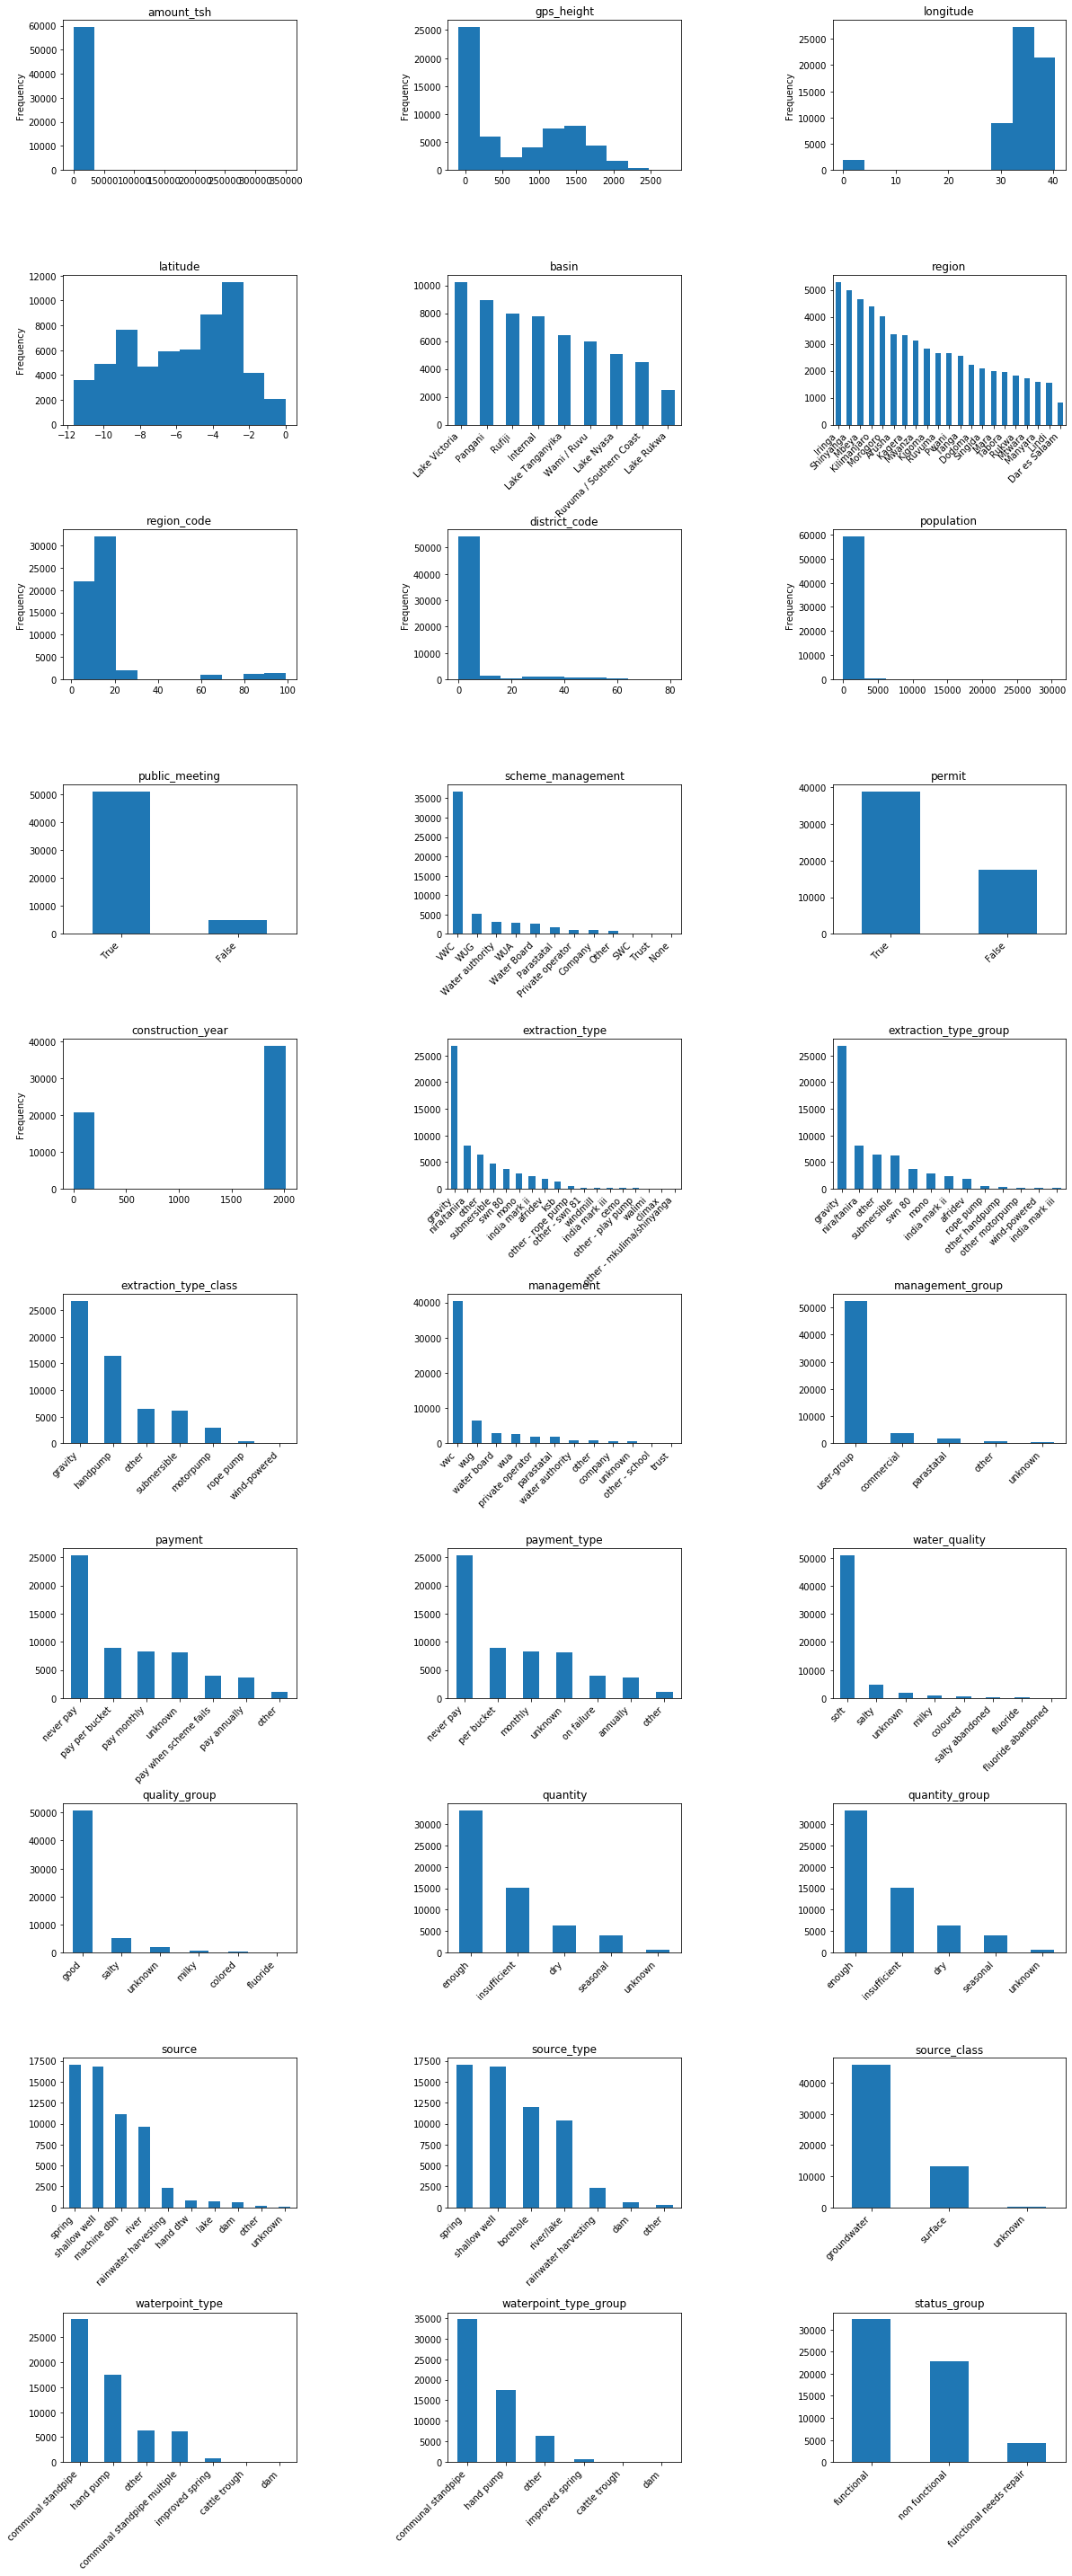

In [0]:
# let's get an idea for how these variables are all distributed
fig, axes = plt.subplots(10,3, figsize=(20,50))

# remove the ones that are useless or have too many values
get_rid_of = ['funder',
             'installer',
             'wpt_name',
             'subvillage',
             'ward',
             'scheme_name',
             'date_recorded',
             'recorded_by',
             'lga',
             'num_private']
new_cols = [i for i in train.columns if i not in get_rid_of]

for i, col in enumerate(new_cols):
  dt = train[col].dtype

  # get the axis for this variable
  ax = axes[i//3, i%3]
  ax.set_title(col)

  # first for the numeric variables, plot a histogram
  if dt=='float64' or dt=='int64':
    train[col].plot.hist(ax=ax)

  # then for the categorical variables, same-ish thing
  else:
    train[col].value_counts().plot(kind="bar", ax=ax)
    # ax.tick_params(axis='x', rotation=70)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


plt.subplots_adjust(wspace=0.65, hspace=0.7)
fig.show()

Interesting. Based on what we can see here it looks like some of the variables won't be as useful for our purposes. The following variables are unlikely to be valuable in a classification task:


*   `num_private`: This variable appears to be mostly zeros with a few exceptions. It also has no description on the data website.
*   `recorded_by`: This variable is the same for every row—it looks like the data was all recorded by "GeoData Consultants Ltd". Clearly this won't help us classify.
*   `latitude` and `longitude`: It seems unlikely that these values will help us classify the data, especially given other categorical data like `subvillage` or `region`. But it may be useful for visualizing our data on a map.

In addition to the above restrictions, several variables appear to be missing some data including `funder`, `population`, `public_meeting`, `scheme_name`, `construction_year`, and others. For effective and accurate classification we will have to find an appropriate way to deal with this missing data.


Finally, it appears that the number of nonfunctional pumps is somewhat less that those that are functional, with far fewer still being "functional needs repair". This could result in difficulties with overrepresentation of the functional pumps and less reliable prediction of those in need of repair. We will investigate oversampling/subsampling methods in order to remedy this problem.

## Visualizations

Let's take a look at some visualizations about these pumps, such as where they are located vs. which ones have failed/are working.



In [0]:
# allow us to look at Tableau visualizations
from IPython.display import Image

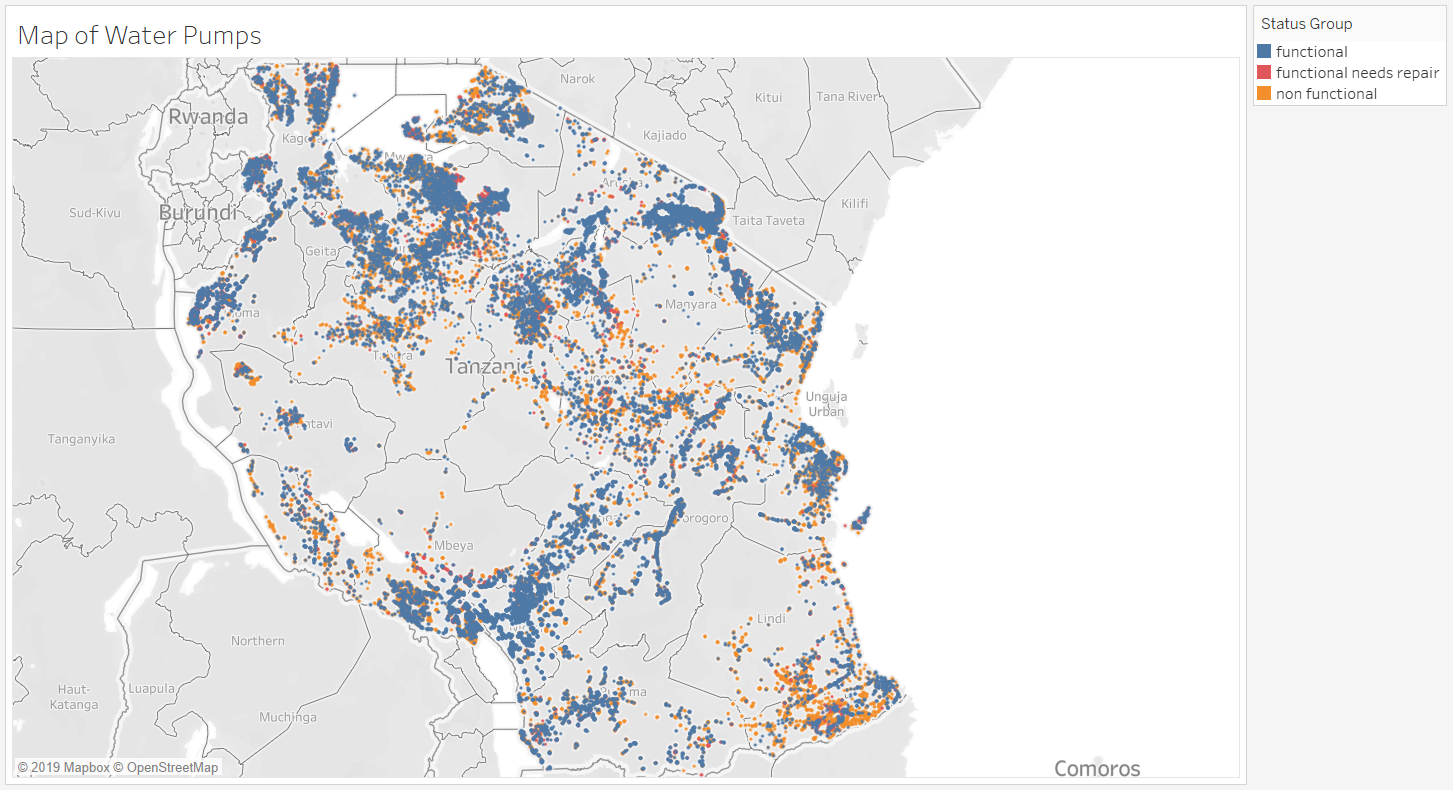

In [0]:
Image('data/map.PNG', width = 1000, height = 550)

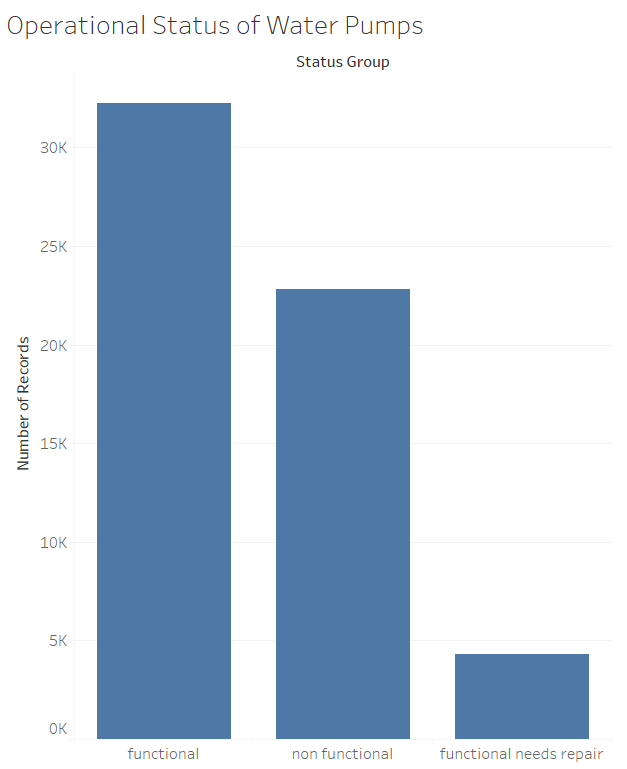

In [0]:
Image('data/Water_pump_status.PNG', width = 400, height = 500)

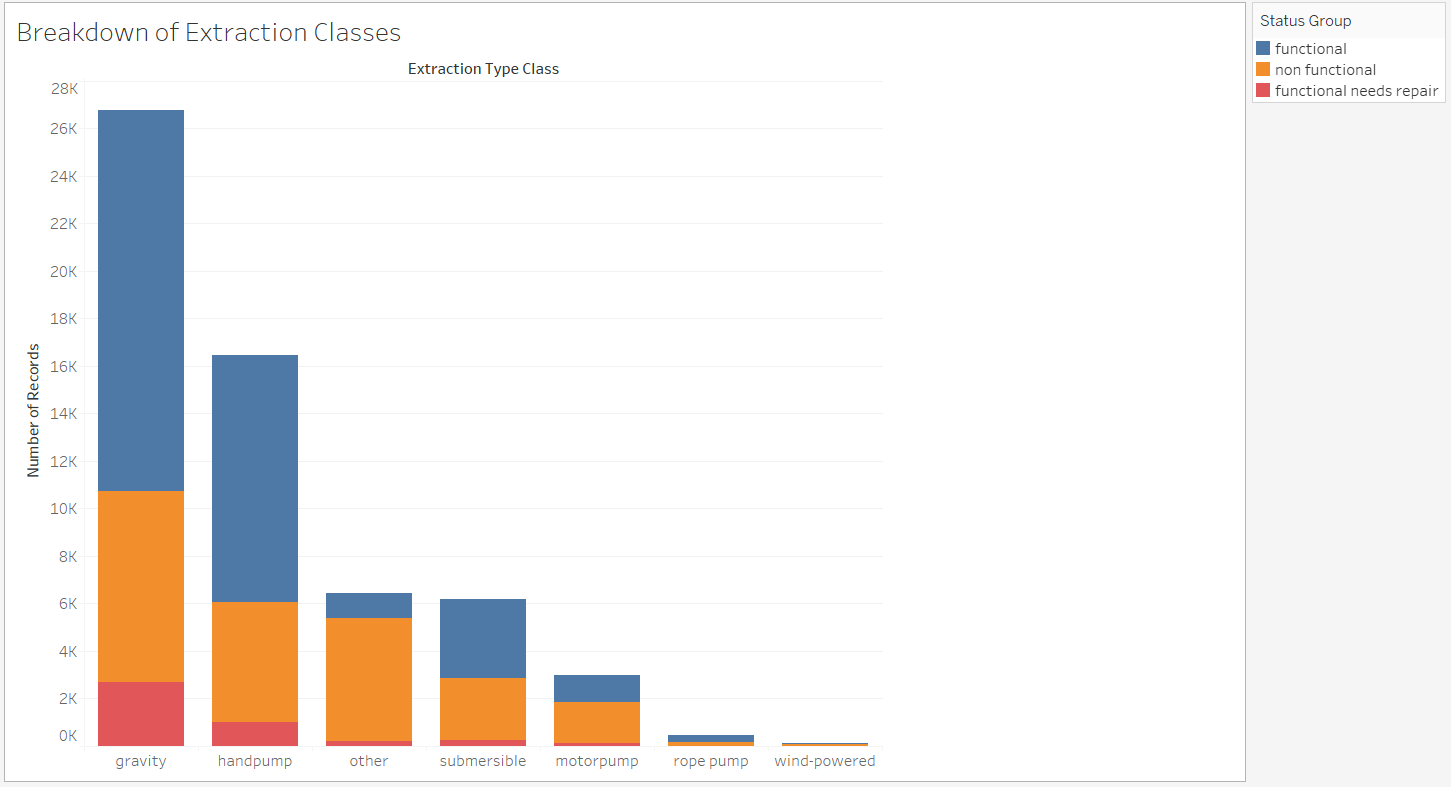

In [0]:
Image('data/Extraction_classes.PNG', width = 750, height = 500)

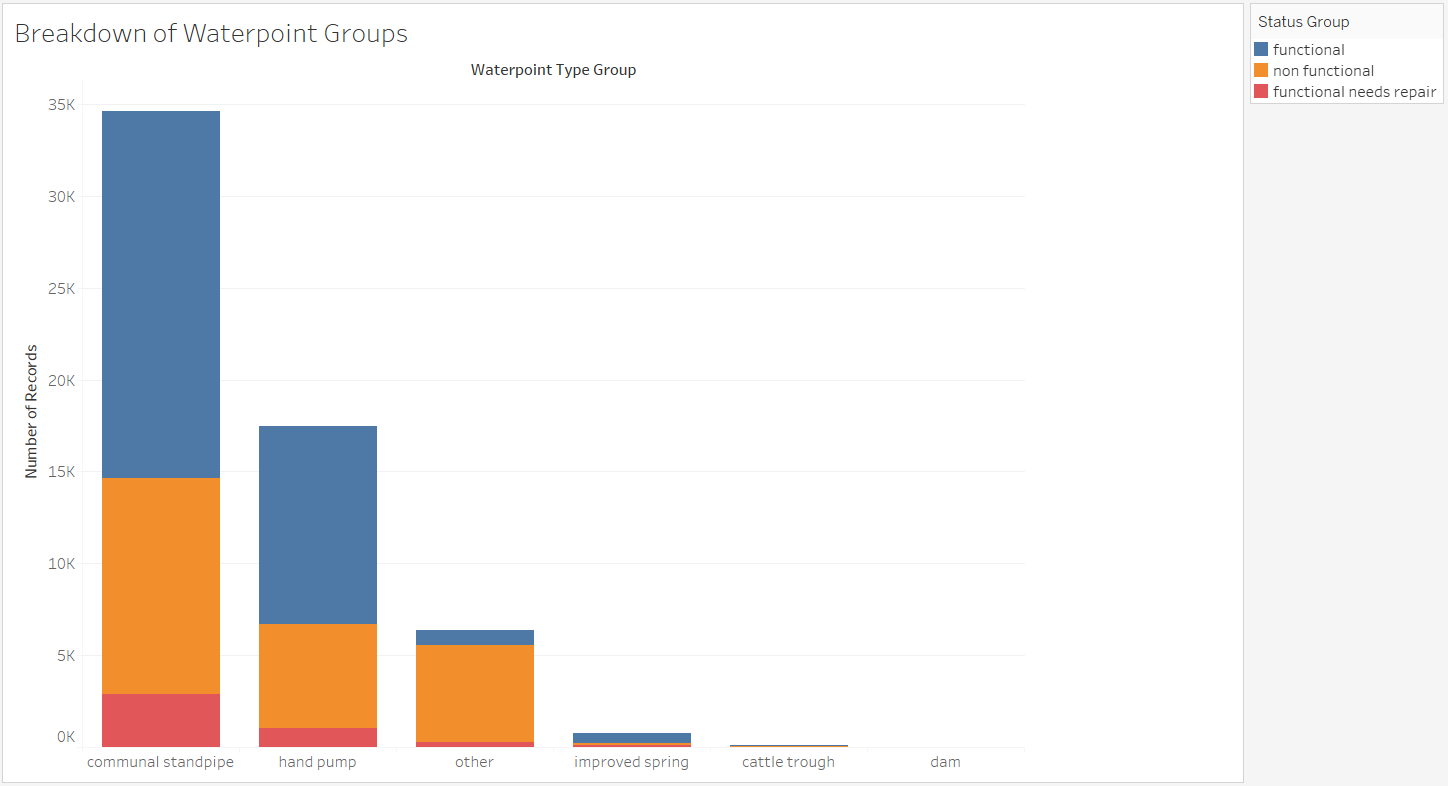

In [0]:
Image('data/Waterpoint_groups.PNG', width = 750, height = 500)

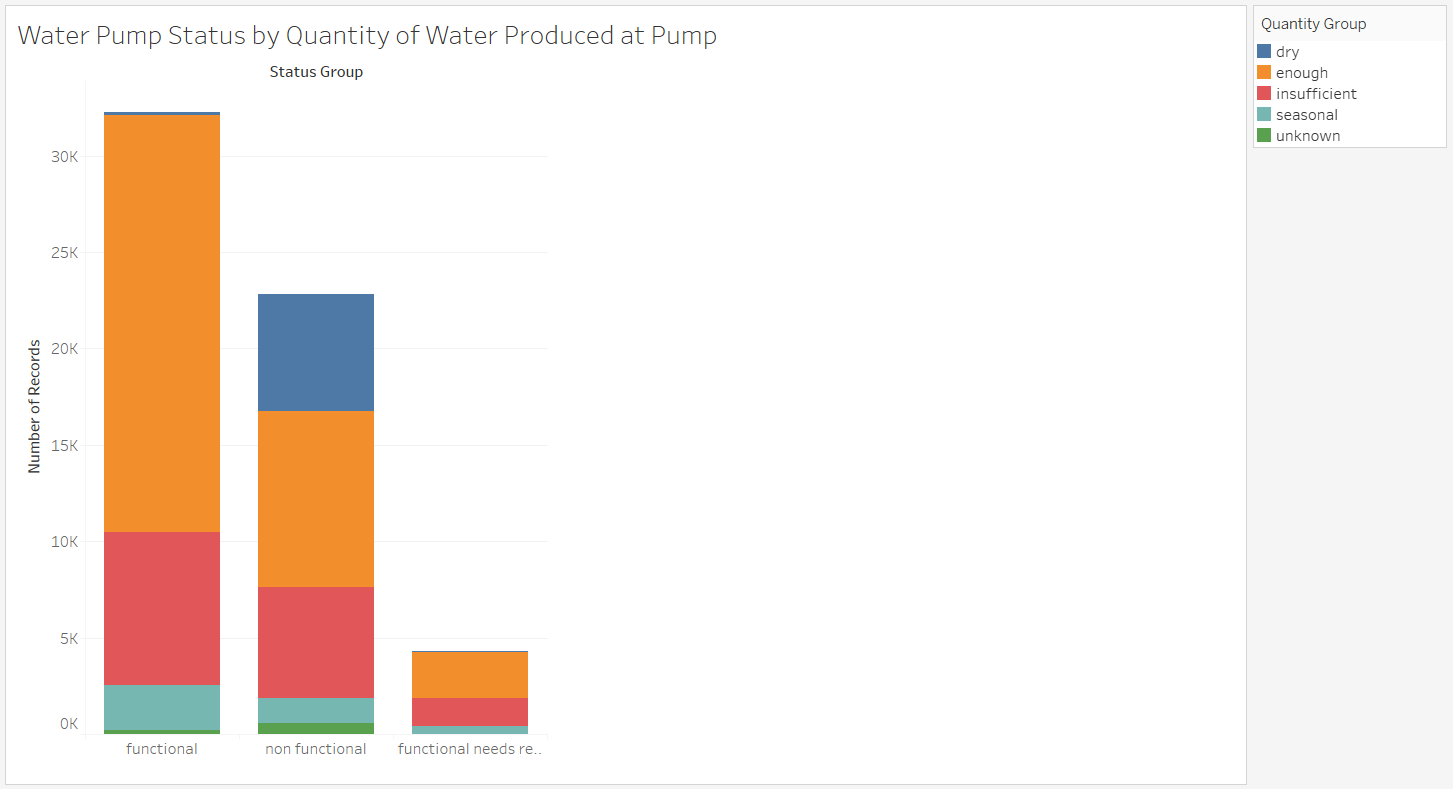

In [0]:
Image('data/Quantity_group.PNG', width = 750, height = 400)

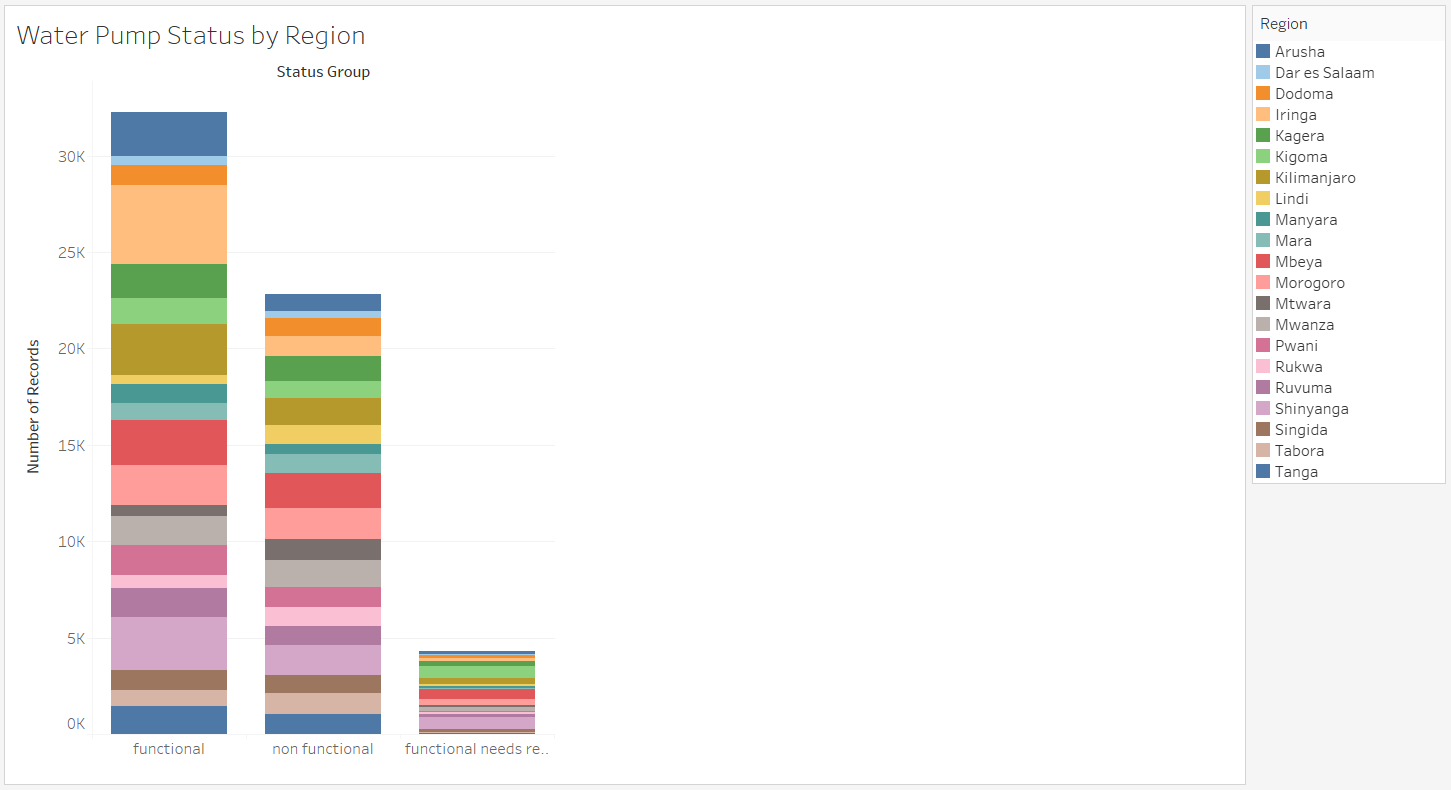

In [0]:
Image('data/Regions.PNG', width = 850, height = 500)

## Conclusions and Insights
After exploring the data, we have some basic insight into how we should proceed.

### Variables and Data Preparation
Some of the most useful variables may be:
*   quantity_group
*   waterpoint_group


Other data considerations include:
*   One decision that may play a significant role in how we proceed is which performance measure to choose. Clearly the most significant value is generated by a model which can accurately predict which pumps either need repair or are nonfunctional (so they can be more rapidly dealt with). However, those classes don't have as many instances as `functional`, so we may need to use some resampling techniques in order to rebalance the data.
*   The `construction_year` feature would immediately seem to be useful, since older water pumps are intuitively more likely to be broken. However, quite a bit of it is missing, and in order to make it more useful in the future it may be better represented as "years since construction". This all means we may need to perform some feature engineering to make the best use of this variable.



### Models
The fact that so many of our attributes are categorical will help guide our choice of model. Some promising candidates are:


*   Naive Bayes: This would be remarkably quick to train, and there may in fact be a number of features that are somewhat independent of one another (the "naive" assumption of this model). We will need to carefully prepare our data so it is ready for this kind of model.
*   Random Forest: Decision trees may be able to make good use of these many categorical variables, and a random forest or other ensemble method will be a good choice to help prevent overfitting.



# Step 3: Prepare the data
Here we need to actually prepare our data for the machine learning process. Feature engineering, cleaning the data, dealing with missing values... all that starts right here.

In [0]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

## Combining Labels
An important decision that we have made at this point is that we will combine the two labels **functional needs repair** and **nonfunctional** into a single category. The advantage of this is threefold:

1.   With only two output labels, our models become simpler and easier to train. This makes the process easier to repeat and build upon for those NGO/government analysts who might be taking over this project once we are finished with it.
2.   This helps us deal with the issue of having too little data about **functional needs repair** pumps, since we can focus on simply predicting those pumps that generally "need attention".
3.   The primary **value added** by this model is as an early warning system for pumps that may need some repair or are completely nonfunctional. Either way, these are the pumps that should be looked at, making the distinction less important.



In [0]:
## Get different classes
multiclass_labels = list(set(train.status_group))

## Convert label column to binary classification problem ('functional' takes on value of 0, 'functional needs repair' and
## 'non functional' take on value of 1)
train['binary_status_group'] = train.status_group   # create new col to store binary labels
train['binary_status_group'] = train['binary_status_group'].map({'functional': 0, 
                                                                 'non functional': 1,
                                                                 'functional needs repair': 1})

In [0]:
train.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,binary_status_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,2012-11-13,Tasaf,0,TASAF,33.125828,-5.118154,Mratibu,0,Lake Tanganyika,Majengo,Tabora,14,3,Uyui,Igalula,0,NaN,GeoData Consultants Ltd,VWC,NaN,True,0,afridev,afridev,handpump,vwc,user-group,unknown,unknown,milky,milky,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,non functional,1
1,0.0,2011-03-05,Shipo,1978,SHIPO,34.770717,-9.395642,NaN,0,Rufiji,Magoda C,Iringa,11,4,Njombe,Uwemba,20,True,GeoData Consultants Ltd,NaN,NaN,False,2008,other - rope pump,rope pump,rope pump,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional,0
2,0.0,2011-03-27,Lvia,0,LVIA,36.115056,-6.279268,Bombani,0,Wami / Ruvu,Songambele,Dodoma,1,4,Chamwino,Msamalo,0,True,GeoData Consultants Ltd,VWC,Mgun,True,0,mono,mono,motorpump,vwc,user-group,pay per bucket,per bucket,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,functional,0
3,10.0,2013-06-03,Germany Republi,1639,CES,37.147432,-3.187555,Area 7 Namba 5,0,Pangani,Urereni,Kilimanjaro,3,5,Hai,Masama Magharibi,25,True,GeoData Consultants Ltd,Water Board,Losaa-Kia water supply,True,1999,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,0
4,0.0,2011-03-22,Cmsr,0,CMSR,36.164893,-6.099289,Ezeleda,0,Wami / Ruvu,Maata A,Dodoma,1,4,Chamwino,Majeleko,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,nira/tanira,nira/tanira,handpump,vwc,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,hand pump,hand pump,non functional,1


## Starting with a simple set of predictors

Below, we keep a relively simple subset of the columns to start with in our baseline setup. These columns all have relatively few unique values, so we can limit the potential complexity of our models. Other potential covariates we may explore later have thousands of unique values, and would thereby require thousands of columns in our transformed dataset for prediction.

In [0]:
## Columns to keep
cols_to_keep = ['amount_tsh', 'basin', 'region', 'population', 'public_meeting', 'scheme_management', 
                'permit', 'construction_year', 'extraction_type_class', 'management', 'management_group', 'payment', 
                'water_quality', 'quantity', 'source_type', 'waterpoint_type_group', 'binary_status_group']
train_subset = train[cols_to_keep]
out_of_sample_subset = out_of_sample_data[cols_to_keep[:-1]]  # subset test data with same cols (exlcuding label column)

In [0]:
train_subset.head()

,amount_tsh,basin,region,population,public_meeting,scheme_management,permit,construction_year,extraction_type_class,management,management_group,payment,water_quality,quantity,source_type,waterpoint_type_group,binary_status_group
id,,,,,,,,,,,,,,,,,
0,0.0,Lake Tanganyika,Tabora,0,NaN,VWC,True,0,handpump,vwc,user-group,unknown,milky,enough,shallow well,hand pump,1
1,0.0,Rufiji,Iringa,20,True,NaN,False,2008,rope pump,vwc,user-group,never pay,soft,enough,shallow well,hand pump,0
2,0.0,Wami / Ruvu,Dodoma,0,True,VWC,True,0,motorpump,vwc,user-group,pay per bucket,soft,insufficient,borehole,communal standpipe,0
3,10.0,Pangani,Kilimanjaro,25,True,Water Board,True,1999,gravity,water board,user-group,pay per bucket,soft,enough,spring,communal standpipe,0
4,0.0,Wami / Ruvu,Dodoma,0,True,VWC,True,0,handpump,vwc,user-group,unknown,soft,dry,shallow well,hand pump,1


In [0]:
## Which columns have NAs?
#len(train_subset)  # see total number of rows
train_subset.describe(include = 'all')

,amount_tsh,basin,region,population,public_meeting,scheme_management,permit,construction_year,extraction_type_class,management,management_group,payment,water_quality,quantity,source_type,waterpoint_type_group,binary_status_group,construction_year_imputed
count,59400.000000,59400,59400,59400.000000,56066,55523,56344,59400.000000,59400,59400,59400,59400,59400,59400,59400,59400,59400.000000,59400.000000
unique,NaN,9,21,NaN,2,12,2,NaN,7,12,5,7,8,5,7,6,NaN,NaN
top,NaN,Lake Victoria,Iringa,NaN,True,VWC,True,NaN,gravity,vwc,user-group,never pay,soft,enough,spring,communal standpipe,NaN,NaN
freq,NaN,10248,5294,NaN,51011,36793,38852,NaN,26780,40507,52490,25348,50818,33186,17021,34625,NaN,NaN
mean,317.650385,NaN,NaN,179.909983,NaN,NaN,NaN,1300.652475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.456919,1996.530657
std,2997.574558,NaN,NaN,471.482176,NaN,NaN,NaN,951.620547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.498145,10.073265
min,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1960.000000
25%,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1996.000000
50%,0.000000,NaN,NaN,25.000000,NaN,NaN,NaN,1986.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1996.000000
75%,20.000000,NaN,NaN,215.000000,NaN,NaN,NaN,2004.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,2004.000000


## Interpolating the construction year
We have 59400 records in our training data, but some of our columns containing missing values. In particular, `public_meeting`, `scheme_management` and `permit` contain missing values. We will need to deal with this, but before we do that, we also need to deal with the `construction_year` column. Although there are no missing records, there are 16567 water pumps with a recorded construction year of 0. To deal with this, we will use mean value imputation.

In [0]:
sum(train_subset.construction_year == 0)  # get number of records with a construction year of 0
imp = SimpleImputer(missing_values = 0, strategy = 'mean')  # mean value imputation
construction_year_imputed = imp.fit_transform(np.array(train_subset.construction_year).reshape(-1, 1))  # new col to store imputed construction year
construction_year_imputed = construction_year_imputed.astype(int)   # convert to int
train_subset['construction_year_imputed'] = construction_year_imputed  # create new col in training data

sum(out_of_sample_subset.construction_year == 0)  # get number of records with a construction year of 0
out_of_sample_construction_year_imputed = imp.fit_transform(np.array(out_of_sample_subset.construction_year).reshape(-1, 1))  # new col to store imputed construction year
out_of_sample_construction_year_imputed = out_of_sample_construction_year_imputed.astype(int)   # convert to int
out_of_sample_subset['construction_year_imputed'] = out_of_sample_construction_year_imputed  # create new col in training data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


## Removing missing values
Now, back to our issue of missing values in `public_meeting`, `scheme_management` and `permit`. Imputing these categorical values using the mode or some other method is an option that could be explored later, although it introduces bias into our model. The simplest and first approach we take here is to simply ignore records which contain missing values and build models on this smaller subset of complete data. This new subset of our training data, `train_clean`, contains 49841 records.


In [0]:
## train_clean contains all records of train_subset in which there are no missing values
train_clean = train_subset.dropna()
len(train_clean)

49841

In [0]:
out_of_sample_clean = out_of_sample_subset.dropna()
len(out_of_sample_clean)

12498

In [0]:
train_clean.describe(include = 'all')

,amount_tsh,basin,region,population,public_meeting,scheme_management,permit,construction_year,extraction_type_class,management,management_group,payment,water_quality,quantity,source_type,waterpoint_type_group,binary_status_group,construction_year_imputed
count,49841.000000,49841,49841,49841.000000,49841,49841,49841,49841.000000,49841,49841,49841,49841,49841,49841,49841,49841,49841.000000,49841.000000
unique,NaN,9,21,NaN,2,12,2,NaN,7,12,5,7,8,5,7,6,NaN,NaN
top,NaN,Pangani,Iringa,NaN,True,VWC,True,NaN,gravity,vwc,user-group,never pay,soft,enough,spring,communal standpipe,NaN,NaN
freq,NaN,8543,5230,NaN,45360,33554,33942,NaN,23974,34761,44827,21450,43749,28777,15180,30513,NaN,NaN
mean,352.215854,NaN,NaN,172.184507,NaN,NaN,NaN,1302.614956,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.450633,1996.475352
std,2793.448736,NaN,NaN,466.902049,NaN,NaN,NaN,950.938838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.497562,10.187059
min,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1960.000000
25%,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1995.000000
50%,0.000000,NaN,NaN,25.000000,NaN,NaN,NaN,1985.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1996.000000
75%,30.000000,NaN,NaN,200.000000,NaN,NaN,NaN,2004.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,2004.000000


In [0]:
out_of_sample_clean.describe(include = 'all')

,amount_tsh,basin,region,population,public_meeting,scheme_management,permit,construction_year,extraction_type_class,management,management_group,payment,water_quality,quantity,source_type,waterpoint_type_group,construction_year_imputed
count,12498.000000,12498,12498,12498.000000,12498,12498,12498,12498.000000,12498,12498,12498,12498,12498,12498,12498,12498,12498.000000
unique,NaN,9,21,NaN,2,11,2,NaN,7,12,5,7,8,5,7,6,NaN
top,NaN,Pangani,Iringa,NaN,True,VWC,True,NaN,gravity,vwc,user-group,never pay,soft,enough,spring,communal standpipe,NaN
freq,NaN,2101,1289,NaN,11334,8353,8522,NaN,5834,8718,11161,5374,10915,7221,3771,7633,NaN
mean,364.743199,NaN,NaN,176.133461,NaN,NaN,NaN,1289.970795,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997.021924
std,2676.649965,NaN,NaN,470.792910,NaN,NaN,NaN,955.124875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.986764
min,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1960.000000
25%,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1996.000000
50%,0.000000,NaN,NaN,15.000000,NaN,NaN,NaN,1985.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997.000000
75%,30.000000,NaN,NaN,200.000000,NaN,NaN,NaN,2005.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005.000000


From the above, we can see that one of the scheme managment categories is not present in the test data, but is present in the training data. In order to have the same dimensions when we one-hot encode both datasets, we need to find this missing category, and then create a column for it and encode it with all 0s.

In [0]:
set(train_clean.scheme_management) - set(out_of_sample_clean.scheme_management)

{'None'}

## Re-encoding the features
Now, we need to convert our categorical features into one-hot encoded features. We do this below. All features with 3+ different categories are converted to one-hot encoded features using OneHotEncoder. The features `permit` and `public_meeting` are also converted to one-hot features. Both these sets of one-hot encoded features are stored in a new dataframe called `features`. We then add back in the two numeric features, `amount_tsh`, `population` and `construction_year_imputed`, as well as our outcome column (`binary_status_group`).

In [0]:
## Get multiclass categorical columns to one-hot encode
categorical_cols = ['basin', 'region', 'scheme_management', 'extraction_type_class', 'management', 'management_group', 
                    'payment', 'water_quality', 'quantity', 'source_type', 'waterpoint_type_group']
train_categorical_cols = train_clean[categorical_cols]
out_of_sample_categorical_cols = out_of_sample_clean[categorical_cols]

## One-hot encode categorical features
ohe = OneHotEncoder(categories = 'auto')
train_one_hot_features = ohe.fit_transform(train_categorical_cols).toarray()
train_one_hot_feature_labels = ohe.categories_   # get feature names
train_feature_labels = np.concatenate(np.array(train_one_hot_feature_labels))  # create one list with all new feature names
train_features = pd.DataFrame(train_one_hot_features, columns = train_feature_labels)
# train_features.head()
out_of_sample_one_hot_features = ohe.fit_transform(out_of_sample_categorical_cols).toarray()
out_of_sample_one_hot_feature_labels = ohe.categories_   # get feature names
out_of_sample_feature_labels = np.concatenate(np.array(out_of_sample_one_hot_feature_labels))  # create one list with all new feature names
out_of_sample_features = pd.DataFrame(out_of_sample_one_hot_features, columns = out_of_sample_feature_labels)

## One-hot encode the binary features: 'public_meeting' and 'permit'
train_features['public_meeting'] = train_clean['public_meeting'].map({True: 1, False: 0}).reset_index(drop = True)
train_features['permit'] = train_clean['permit'].map({True: 1, False: 0}).reset_index(drop = True)
out_of_sample_features['public_meeting'] = out_of_sample_clean['public_meeting'].map({True: 1, False: 0}).reset_index(drop = True)
out_of_sample_features['permit'] = out_of_sample_clean['permit'].map({True: 1, False: 0}).reset_index(drop = True)


## Add back in numerical columns and outcome/label column
train_features['amount_tsh'] = train_clean['amount_tsh'].reset_index(drop = True)
train_features['population'] = train_clean['population'].reset_index(drop = True)
train_features['construction_year'] = train_clean['construction_year_imputed'].reset_index(drop = True)
train_features['status_group'] = train_clean['binary_status_group'].reset_index(drop = True)

out_of_sample_features['amount_tsh'] = out_of_sample_clean['amount_tsh'].reset_index(drop = True)
out_of_sample_features['population'] = out_of_sample_clean['population'].reset_index(drop = True)
out_of_sample_features['construction_year'] = out_of_sample_clean['construction_year_imputed'].reset_index(drop = True)
out_of_sample_features['None'] = 0     # include missing feature category from scheme management

In [0]:
train_features.head()

,Internal,Lake Nyasa,Lake Rukwa,Lake Tanganyika,Lake Victoria,Pangani,Rufiji,Ruvuma / Southern Coast,Wami / Ruvu,Arusha,Dar es Salaam,Dodoma,Iringa,Kagera,Kigoma,Kilimanjaro,Lindi,Manyara,Mara,Mbeya,Morogoro,Mtwara,Mwanza,Pwani,Rukwa,Ruvuma,Shinyanga,Singida,Tabora,Tanga,Company,None,Other,Parastatal,Private operator,SWC,Trust,VWC,WUA,WUG,...,user-group,never pay,other,pay annually,pay monthly,pay per bucket,pay when scheme fails,unknown,coloured,fluoride,fluoride abandoned,milky,salty,salty abandoned,soft,unknown,dry,enough,insufficient,seasonal,unknown,borehole,dam,other,rainwater harvesting,river/lake,shallow well,spring,cattle trough,communal standpipe,dam,hand pump,improved spring,other,public_meeting,permit,amount_tsh,population,construction_year,status_group
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0.0,0,1996,0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,10.0,25,1999,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,0.0,0,1996,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0,50.0,6922,1996,0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1,0.0,0,1996,1


In [0]:
out_of_sample_features.head()

,Internal,Lake Nyasa,Lake Rukwa,Lake Tanganyika,Lake Victoria,Pangani,Rufiji,Ruvuma / Southern Coast,Wami / Ruvu,Arusha,Dar es Salaam,Dodoma,Iringa,Kagera,Kigoma,Kilimanjaro,Lindi,Manyara,Mara,Mbeya,Morogoro,Mtwara,Mwanza,Pwani,Rukwa,Ruvuma,Shinyanga,Singida,Tabora,Tanga,Company,Other,Parastatal,Private operator,SWC,Trust,VWC,WUA,WUG,Water Board,...,user-group,never pay,other,pay annually,pay monthly,pay per bucket,pay when scheme fails,unknown,coloured,fluoride,fluoride abandoned,milky,salty,salty abandoned,soft,unknown,dry,enough,insufficient,seasonal,unknown,borehole,dam,other,rainwater harvesting,river/lake,shallow well,spring,cattle trough,communal standpipe,dam,hand pump,improved spring,other,public_meeting,permit,amount_tsh,population,construction_year,None
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1,0.0,321,2012,0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0.0,300,2000,0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0.0,200,1990,0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,0.0,600,2007,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1,0.0,1,1982,0


# Step 4: Prediction
Here, we use our transformed dataset to train various models to predict water pump failure. We also run our model on the out-of-sample data (no indication of the true status of the pump) provided from our data source, and generate predictions of which waterpumps we believe need repair and/or are at risk of failure, and therefore require attention. The ultimate value add from this is an early warning system to detect water pumps which may require attention so that access to water is not disrupted for those who frequent the listed pumps for water.

**Note:** In the tradeoff between false negatives and false positives, we would rather have high false positives (flagging a water pump as not functioning when it is functioning) than false negatives (flagging a water pump as functioning when it is not functioning). This is a parameter that can be tuned in many of our models, allowing for higher _recall_ at the possible expense of some _precision_. Thus, if it is determined that more value would be added by reversing this preference, it is a simple matter to change.


In [0]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn import tree
import graphviz     # install using: conda install -c anaconda graphviz
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [0]:
def conf_matrix_report(true_labels, predicted_labels):
    '''
    Compute confusion matrix, and returns matrix as a dictionary, as well as true positive rate, true negative rate,
    false positive rate, and false negative rate.
    '''
    tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()
    conf_mat = {'true positives': tp, 'false positives': fp, 'false negatives': fn, 'true negatives': tn}
    
    tpr = tp / (tp + fp)
    tnr = fn / (fn + tn)
    fpr = fp / (fp + tp)
    fnr = fn / (fn + tn)
    metrics = {'tpr': tpr, 'tnr': tnr, 'fpr': fpr, 'fnr': fnr}
    
    return conf_mat, metrics

### Binary Logistic Regression

We dive into our goal of predicting water pump failure using binary logistic regression. In the code cell below, we take our entire training dataset and implement cross validation to train our model, report classification accuracy, and predict on out-of-sample test data. The resulting model yields a classification accuracy of 74%. 


In [0]:
## Train logistic regression model
x_train = train_features.iloc[:, :-1]
y_train = np.array(train_features.iloc[:, -1:]).ravel()
logit = LogisticRegressionCV(max_iter = 1000).fit(X = x_train, y = y_train)

## Return accuracy of model
logit_accuracy = logit.score(x_train, y_train)
print('Logisitic Regression Accuracy:', logit_accuracy)

## Return confusion matrix results
conf_mat, metrics = conf_matrix_report(true_labels = y_train, predicted_labels = logit.predict(X = x_train))
print('confusion matrix:', conf_mat)
print('metrics:', metrics)

## Make out-of-sample predictions
logit_out_of_sample_predictions = logit.predict(X = out_of_sample_features)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Logisitic Regression Accuracy: 0.7409361770429967
confusion matrix: {'true positives': 13368, 'false positives': 3820, 'false negatives': 9092, 'true negatives': 23561}
metrics: {'tpr': 0.777751919944147, 'tnr': 0.2784430220806664, 'fpr': 0.22224808005585292, 'fnr': 0.2784430220806664}


## K Nearest Neighbors
Now we'll investigate the possibility that there is a simpler solution to determining which pumps need attention: a k-nearest neighbors "vote". Although this can be a resource intensive algorithm for prediction, training time is instantaneous and it is highly explainable for stakeholders who are less technically inclined.

This model also results in an accuracy of 74%, no better than the above attempt with Logistic Regression. The one advantage is that it appears to have reduced the False Negative rate somewhat. It is possible that our data is too high dimensional to give promising results with a KNN classifier.

In [0]:
## Split data into train and test data
X_train, X_test, y_train, y_test = train_test_split(train_features.iloc[:, :-1], 
                                                    np.array(train_features.iloc[:, -1:]).ravel(), 
                                                    test_size = 0.1, random_state=1)

In [0]:
## Use cross validation to get the hyperparameter k (number of neighbors) just right
parameters = {'n_neighbors': range(3,11,2)}
clf = GridSearchCV(KNeighborsClassifier(), parameters, n_jobs=4)
clf.fit(X = X_train, y = y_train)
knn = clf.best_estimator_    # this should give us the best value for k
print('Number of neighbors k:', knn.get_params()['n_neighbors'])

## Evaluate knn on test set and return accuracy of model
predicted_y_test = clf.predict(X = X_test)
knn_accuracy = knn.score(X_test, y_test)
print('K Nearest Neighbors Train Accuracy:', knn_accuracy)

## Return confusion matrix results for test data
conf_mat, metrics = conf_matrix_report(true_labels = y_test, predicted_labels = knn.predict(X = X_test))
print('confusion matrix:', conf_mat)
print('metrics:', metrics)

## Make out of sample predictions
knn_out_of_sample_predictions = knn.predict(X = out_of_sample_features)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Number of neighbors k: 5
K Nearest Neighbors Train Accuracy: 0.7362086258776329
confusion matrix: {'true positives': 1453, 'false positives': 559, 'false negatives': 756, 'true negatives': 2217}
metrics: {'tpr': 0.7221669980119284, 'tnr': 0.2542885973763875, 'fpr': 0.2778330019880716, 'fnr': 0.2542885973763875}


## Decision Tree

Next, we look at a classic binary classification approach, the decision tree. Here again, we want to avoid overfitting our data, so that our model can generalize to unseen data — and actually work well in the real world! To do this, we split our data into a training set on which we build our decision tree with cross validation, and a small sample of our dataset (10% of the data) as the test set, which we use as a proxy for real-time prediction on data the model has not seen. This serves as the test for how well we can actually detect issues with water pumps.

In the results below, the decision tree is able to boost accuracy up to 79%. We run the same out-of-sample predictions on unseen data with no labels (no indication of the true status of the pump), and present these findings as supporting evidence for Tanzanian NGO and government officials to further inspect the listed pumps for potential issues.

In [0]:
## Split data into train and test data
X_train, X_test, y_train, y_test = train_test_split(train_features.iloc[:, :-1], 
                                                    np.array(train_features.iloc[:, -1:]).ravel(), 
                                                    test_size = 0.1, random_state=1)

In [0]:
## Train decision tree using cross validation to select best depth (to avoid overfitting)
parameters = {'max_depth': range(3, 25)}  # evalaue models over depths
clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs = 4)
clf.fit(X = X_train, y = y_train)
tree_model = clf.best_estimator_    # select best max_depth from cross validation estimates of error

## Evaluate decision tree on test set and return accuracy of model
predicted_y_test = clf.predict(X = X_test)
dtree_accuracy = tree_model.score(X_test, y_test)
print('Decision Tree Train Accuracy:', dtree_accuracy)

## Return confusion matrix results for test data
conf_mat, metrics = conf_matrix_report(true_labels = y_test, predicted_labels = tree_model.predict(X = X_test))
print('confusion matrix:', conf_mat)
print('metrics:', metrics)

## Make out of sample predictions
dtree_out_of_sample_predictions = tree_model.predict(X = out_of_sample_features)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Decision Tree Train Accuracy: 0.7899699097291876
confusion matrix: {'true positives': 1585, 'false positives': 423, 'false negatives': 624, 'true negatives': 2353}
metrics: {'tpr': 0.7893426294820717, 'tnr': 0.2096069868995633, 'fpr': 0.2106573705179283, 'fnr': 0.2096069868995633}


## Random Forest

In our final approach, we aim to improve upon our decision tree approach by making use of random forests. This approach is used to combat the overfitting decision trees can be susceptible to, and essentially makes use of the predictions of many decision trees to make an averaged out prediction.

As can be seen, this model performs much better, with nearly 90% accuracy! This is substantially better than our other models, and translates into the following real-world application: with 88% accuracy, we can predict which water pumps are failing or have already failed.

In [0]:
## Train decision tree using cross validation to select best depth (to avoid overfitting)
x_train = train_features.iloc[:, :-1]
y_train = np.array(train_features.iloc[:, -1:]).ravel()
parameters = {'max_depth': range(3, 25)}  # evalaue models over depths
clf = GridSearchCV(RandomForestClassifier(), parameters, n_jobs = 4)
clf.fit(X = x_train, y = y_train)
forest_model = clf.best_estimator_    # select best max_depth from cross validation estimates of error

## Evaluate decision tree on test set and return accuracy of model
forest_accuracy = forest_model.score(x_train, y_train)
print('Random Forest Accuracy:', forest_accuracy)

## Return confusion matrix results for test data
conf_mat, metrics = conf_matrix_report(true_labels = y_train, predicted_labels = forest_model.predict(X = x_train))
print('confusion matrix:', conf_mat)
print('metrics:', metrics)

## Make out of sample predictions
forest_out_of_sample_predictions = forest_model.predict(X = out_of_sample_features)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest Accuracy: 0.8584498705884713
confusion matrix: {'true positives': 17016, 'false positives': 1611, 'false negatives': 5444, 'true negatives': 25770}
metrics: {'tpr': 0.9135126429376711, 'tnr': 0.17440891907477413, 'fpr': 0.08648735706232888, 'fnr': 0.17440891907477413}


## The Best Model for the Job
When evaluating our results across the four models implemented, Random Forest yields noticebaly better detection accuracy than the other models. Thus, we will proceed with our recommendations as to which pumps we believe are at risk of issues or failure using our Random Forest model.

In [0]:
sum(forest_out_of_sample_predictions) # number of pumps we determined need inspection

12150

In [0]:
## Add predicted status ('functional' vs 'needs inspection') back to our out-of-sample dataset
out_of_sample_clean['status_group'] = forest_out_of_sample_predictions
out_of_sample_clean['status_group'] = out_of_sample_clean['status_group'].map({1: 'needs inspection', 0: 'functional'})

## Return out-of-sample dataset with the same columns and ordering as we took in, with our predicted status added in
out_of_sample_final = pd.merge(left = out_of_sample_data, right = 
                               out_of_sample_clean['status_group'], 
                               left_index = True, right_index = True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
## Get predicted pump status and write it out to a .csv file with water pump IDs and additional data added
out_of_sample_final.to_csv('water_pump_status_predictions.csv')

# Step 5: Results and Value Added
Let's take a look at where pumps we believe are not functioning properly are located. Additionally, we quantify the amount of water these pumps would no longer deliver in the even of failure, as well as the number of Tanzanians that would be impacted by these pumps potentially failing.

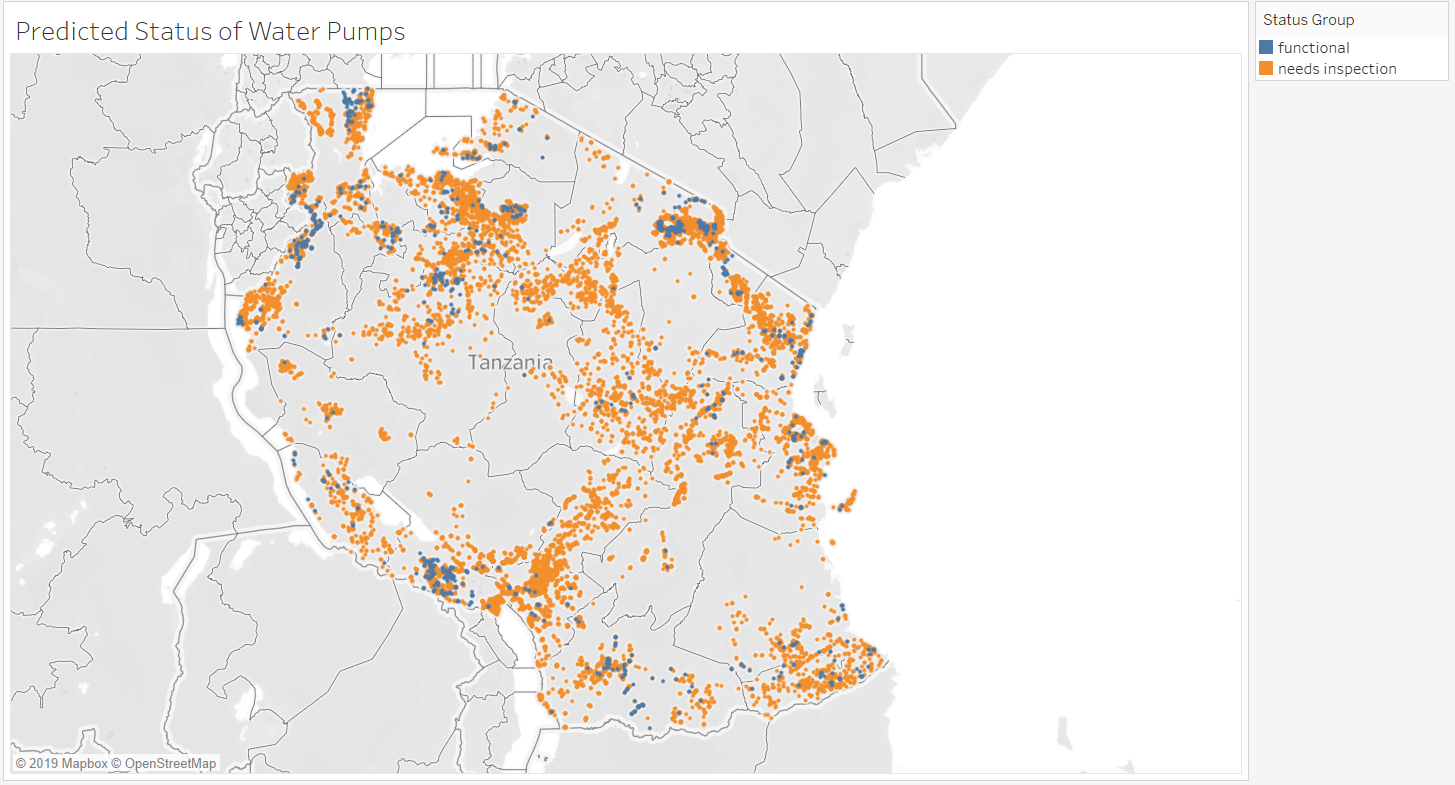

In [0]:
Image('data/Map_predicted_pump_status.PNG', width = 1000, height = 550)

In [0]:
## How much water (measured in total static head) are the pumps that need inspection currently providing?
out_of_sample_clean[out_of_sample_clean['status_group'] == 'needs inspection'].amount_tsh.sum()

4430900.5

In [0]:
## How many people (in millions) will be impacted by the pumps we have flagged as needing inspection?
out_of_sample_clean[out_of_sample_clean['status_group'] == 'needs inspection'].population.sum()

2117939

The value of this project to organizations like [Taarifa](http://taarifa.org/) and the [Tanzanian Ministry of Water](http://maji.go.tz/) is crystal clear: **a machine learning model like ours allows highly accurate prediction of waterpump failure across Tanzania, which saves time and therefore resources for organizations that seek to alleviate the water crisis in Tanzania**. This approach can save valuable time inspecting pumps that do not need attention and devoting those resources instead to pumps that are likely to go bad. As a result, thousands of people are gifted with more timely and uninterrupted access to this precious and irreplaceable resource.

Based on our predictions above, our model could help facilitate access to clean water to more than 2 million Tanzanians. This is of tremendous value, and with further work and tuning the model could likely be made even more accurate, thus benefiting more individuals and communities.

## Next Steps
Although the results above are promising and valuable on their own, we believe this model can be pushed even further. Future work to enable even greater outcomes could include the following:

*   **Exploring models that classify all three categories:** That is, models that will distinguish between nonfunctional pumps and those that simply need some repair. This would be useful for allocating limited resources to those pumps in areas that are most in need of assistance. 

*   **Identifying the most underserved areas as the most pressing targets:** In our predicted map above, it is clear that there are entire regions with pumps that are in need of attention. If we could pinpoint the pumps in those regions that serve the _most_ people and/or provide the _most_ clean water, it would enable organizations to maximize their impact as they set out to repair those water pumps.

*   **Challenging and examining our assumptions and hyperparameters:** We made a number of simplifying decisions in the course of preparing our data that may have impacted performance. Next steps should include exploration of alternative ways to deal with missing data and feature selection for prediction. Increasing accuracy should always be a priority so as to avoid wasting resources.

*   **Building a robust machine learning pipeline:** As these pumps are in fact repaired and inspected, a pipeline should be built out that allows stale data to be updated and new observations to be added. This will allow for something closer to an "online learning" approach, which will take new data into account and—hopefully—improve the performance of our predictive models.

